In [8]:
%pip install matplotlib
%pip install opencv-python
%pip install numpy
%pip install scikit-image


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import matplotlib.pyplot as plt
import sys
import os

In [10]:
sys.path.append(os.path.abspath('/Users/risanawa/Downloads/CSE5504_project-1/src'))

In [11]:
import preprocessing
import segmentation

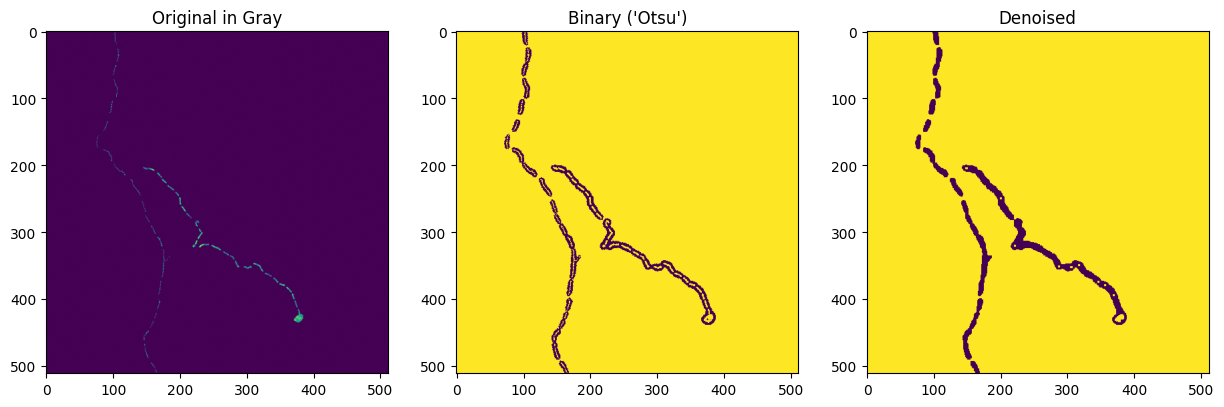

In [12]:
# 1. load image 
image_path = "/Users/risanawa/Downloads/CSE5504_project-1/data/easy/000037.tif"
original = preprocessing.load_image(image_path)
gray = preprocessing.convert_to_gray(original)

# 2. test : "EASY"
binary_easy = preprocessing.binarize_image(gray, method='adaptive')
cleaned_easy = preprocessing.denoise(binary_easy)

#3. check results
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(gray)
ax[0].set_title("Original in Gray")

ax[1].imshow(binary_easy)
ax[1].set_title("Binary ('Otsu')")

ax[2].imshow(cleaned_easy)
ax[2].set_title("Denoised")

plt.show()

Detected White Background... Inverting to Black Background.


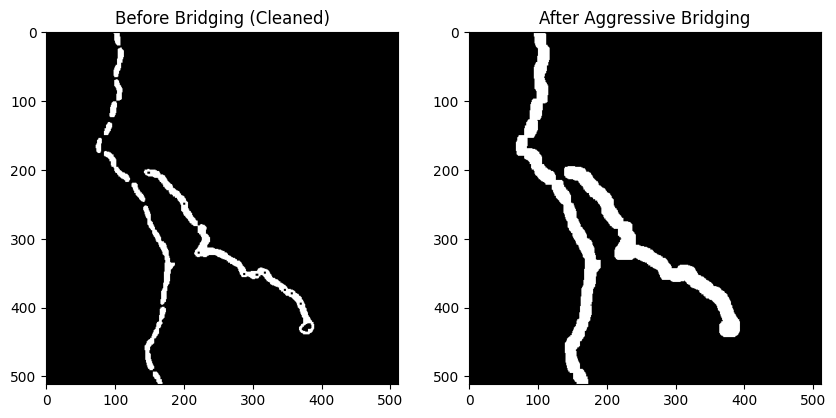

Total blobs found (including noise): 2
Valid neurons found: 2


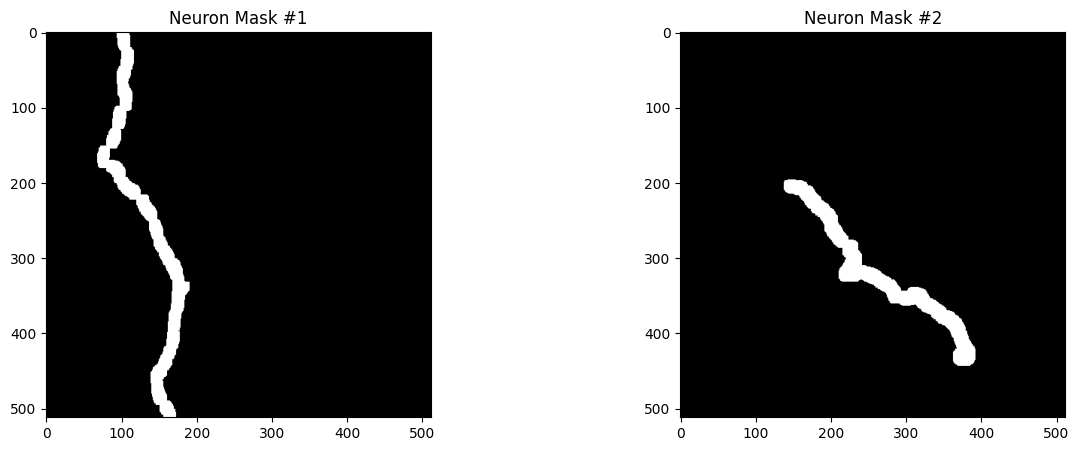

In [13]:
import matplotlib.pyplot as plt
import preprocessing
import segmentation # Import our new module
import cv2
import numpy as np

# 1. Load and Preprocess (Reuse previous steps)
img_path = "/Users/risanawa/Downloads/CSE5504_project-1/data/easy/000037.tif"
original = preprocessing.load_image(img_path)
gray = preprocessing.convert_to_gray(original)
binary = preprocessing.binarize_image(gray, method="adaptive")
cleaned = preprocessing.denoise(binary)

# --- STEP 1: FORCE STANDARD COLORS (Black Background, White Neuron) ---
# Calculate the average color. If it's high (>127), the background is white.
if np.mean(cleaned) > 127:
    print("Detected White Background... Inverting to Black Background.")
    cleaned = cv2.bitwise_not(cleaned)

# --- STEP 2: AGGRESSIVE BRIDGING ---
# We use a larger kernel and pure Dilation to force the dots to touch.
# Don't worry if the neuron looks "fat" here. We want it connected.
# The Skeletonization step later will make it thin again.
kernel_size = 5
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Dilate 3 times. This expands the white neuron by ~15 pixels total.
bridged_image = cv2.dilate(cleaned, kernel, iterations=2)

# --- STEP 3: VISUALIZE ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Before Bridging (Cleaned)")
plt.imshow(cleaned, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("After Aggressive Bridging")
plt.imshow(bridged_image, cmap='gray')
plt.show()

# Now use THIS image for segmentation instead of 'cleaned'
num_labels, labels, stats, centroids = segmentation.cca(bridged_image)

# 2. Run Segmentation
print(f"Total blobs found (including noise): {num_labels - 1}")

# 3. Get Individual Masks
neuron_masks = segmentation.get_valid_obj(num_labels, labels, stats, min_area=500)
print(f"Valid neurons found: {len(neuron_masks)}")

# 4. Visualize
# We will display the first 3 valid masks found
fig, ax = plt.subplots(1, max(len(neuron_masks), 1), figsize=(15, 5))

if len(neuron_masks) == 0:
    print("No neurons found!")
else:
    for i, mask in enumerate(neuron_masks):
        # Handle cases with 1 or multiple subplots
        if len(neuron_masks) > 1:
            ax[i].imshow(mask, cmap="gray")
            ax[i].set_title(f"Neuron Mask #{i+1}")
        else:
            ax.imshow(mask, cmap="gray")
            ax.set_title(f"Neuron Mask #{i+1}")
            
plt.show()

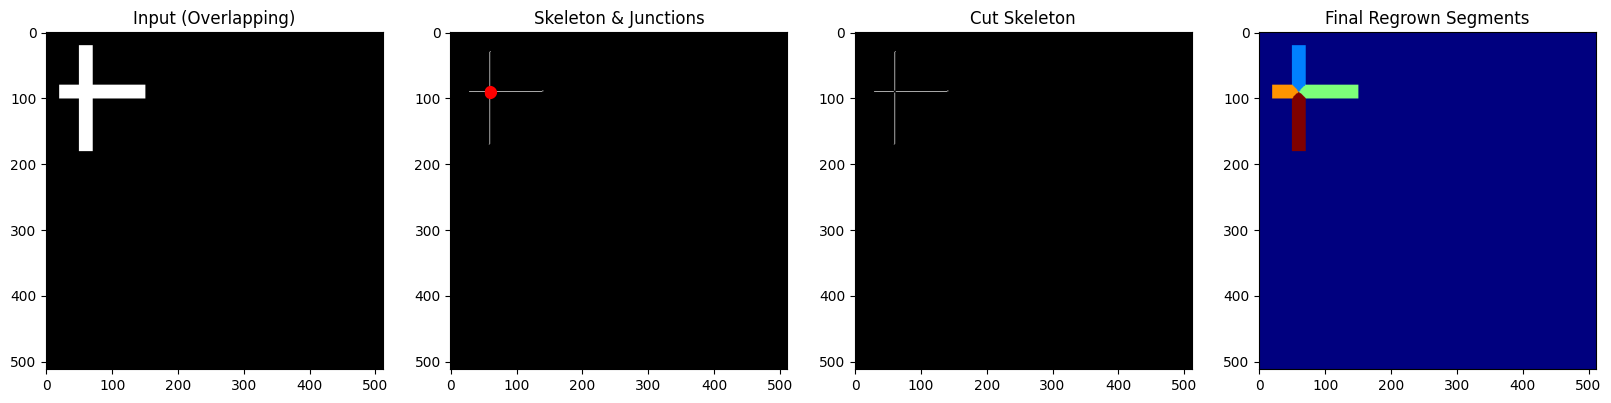

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import preprocessing
import untangling
import cv2

# 1. Load a "Medium" or "Hard" image (where overlaps exist)
# If you don't have one, stick to the easy one, but the code won't trigger the 'cut' 
# unless there is an overlap.
img_path = "/Users/risanawa/Downloads/CSE5504_project-1/data/easy/000037.tif"
original = preprocessing.load_image(img_path)
gray = preprocessing.convert_to_gray(original)
binary = preprocessing.binarize_image(gray, method="otsu")
cleaned = preprocessing.denoise(binary)

if np.mean(cleaned) > 127:
    print("Detected White Background... Inverting to Black Background.")
    cleaned = cv2.bitwise_not(cleaned)

# --- STEP 2: AGGRESSIVE BRIDGING ---
kernel_size = 5
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Dilate 3 times. This expands the white neuron by ~15 pixels total.
bridged_image = cv2.dilate(cleaned, kernel, iterations=2)

# 2. Force an Artificial Overlap (For Testing Only)
# If your image is simple, let's MAKE it complex to test the algorithm.
# We will draw a cross shape.
complex_blob = np.zeros_like(bridged_image)
cv2.rectangle(complex_blob, (50, 20), (70, 180), 255, -1) # Vertical bar
cv2.rectangle(complex_blob, (20, 80), (150, 100), 255, -1) # Horizontal bar
# Now we have a "+" sign which is a single blob but 2 "neurons"

# 3. Run Untangling
skeleton = untangling.get_skeleton(complex_blob)
junctions = untangling.find_junctions(skeleton)
cut_skel = untangling.cut_skeleton(skeleton, junctions)
final_labels = untangling.regrow_segments(cut_skel, complex_blob)

# 4. Visualize Steps
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(complex_blob, cmap='gray')
ax[0].set_title("Input (Overlapping)")

ax[1].imshow(skeleton, cmap='gray')
ax[1].scatter(junctions[:, 1], junctions[:, 0], c='red', s=50) # Plot red dots on junctions
ax[1].set_title("Skeleton & Junctions")

ax[2].imshow(cut_skel, cmap='gray')
ax[2].set_title("Cut Skeleton")

# Display final with distinct colors for each neuron
ax[3].imshow(final_labels, cmap='jet') 
ax[3].set_title("Final Regrown Segments")

plt.show()